In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

In [2]:
file_path = 'spec-6476-56358-0650.fits'
t = Table.read(file_path)

t

flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
float32,float32,float32,int32,int32,float32,float32,float32
36.311607,3.5571,0.02647404,0,0,1.1605932,5.2503796,30.977335
31.581005,3.5572,0.027193226,0,0,1.1607782,4.788879,31.064526
26.368147,3.5573,0.029743887,0,0,1.1602511,4.4398003,30.048332
40.61604,3.5574,0.0244861,0,0,1.1607729,4.3273525,30.219416
40.395905,3.5575,0.026089525,0,0,1.1608392,4.3071427,30.754435
41.02365,3.5576,0.023132984,0,0,1.1604986,4.353813,30.077955
49.249195,3.5577,0.02675654,0,0,1.1592796,4.3352733,29.2201
22.113743,3.5578,0.029651104,0,0,1.1585904,4.4097004,29.513203
47.49873,3.5579,0.024409276,0,0,1.1594409,4.805399,30.52793


# Data

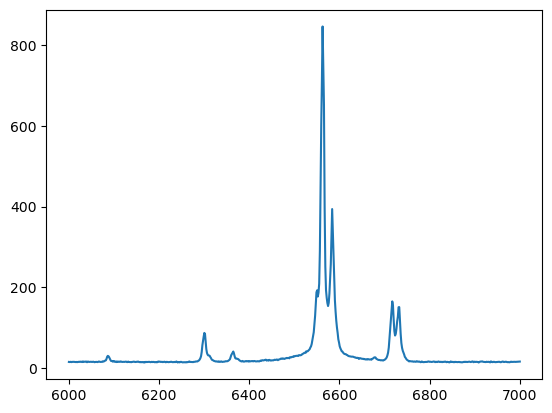

In [36]:
file_path = 'spec-6476-56358-0650.fits'

t = Table.read(file_path)
t.sort('loglam')

z = 0.06342521
wl = (10**t['loglam']) / (1+z)
flux = t['flux']
err = t['ivar']

#flux_lim = np.where(flux>0)[0]
#wl=wl[flux_lim]
#flux=flux[flux_lim]
#err=err[flux_lim]

wl_lim = np.where((wl>6000)&(wl<7000))
wl=wl[wl_lim]
flux=flux[wl_lim]
err=err[wl_lim]

#mask1 = np.where((wl<6570)|(wl>6590))
#wl=wl[mask1]
#flux=flux[mask1]
#err=err[mask1]

plt.plot(wl, flux)
#plt.xlim(5500, 7500)
#plt.ylim(-1, 100)
plt.show()

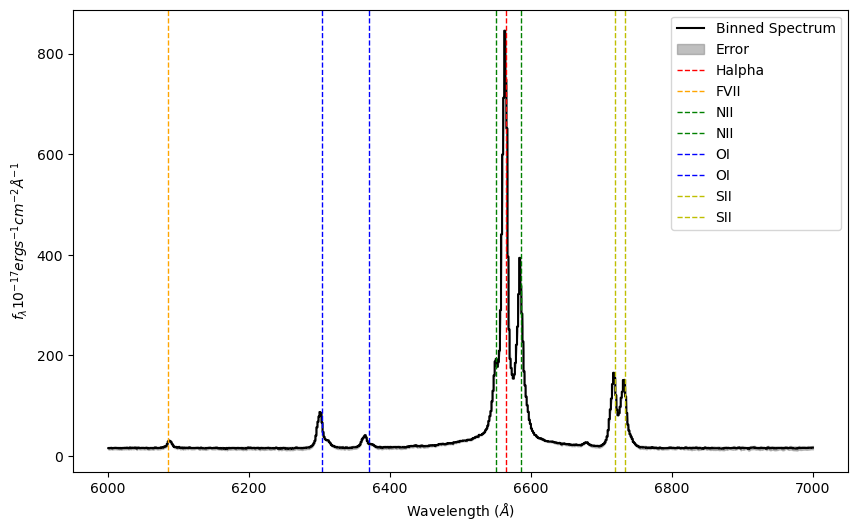

In [38]:
bin_width = 1

bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(err[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
plt.axvline(x=6085.90, color='orange', linestyle='--', linewidth=1, label="FVII")
plt.axvline(x=6551.06, color='g', linestyle='--', linewidth=1, label="NII")
plt.axvline(x=6585.64, color='g', linestyle='--', linewidth=1, label="NII")
plt.axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
plt.axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
plt.axvline(x=6719, color='y', linestyle='--', linewidth=1, label="SII")
plt.axvline(x=6734, color='y', linestyle='--', linewidth=1, label="SII")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
#plt.xlim(5900, 6900)
#plt.ylim(0, 100)
plt.legend()
plt.show()

## Functions

In [39]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [40]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [41]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [84]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         sii1_f,sii1_cent,sii1_fwhm,\
                         sii2_f,sii2_cent,sii2_fwhm,\
                         fvii_f,fvii_cent,fvii_fwhm,\
                         oi1_f,oi1_cent,oi1_fwhm,\
                         oi2_f,oi2_cent,oi2_fwhm,\
                         nii1_f,nii1_cent,nii1_fwhm,\
                        nii2_f,nii2_cent,nii2_fwhm,\
                         halpha_f,halpha_cent,halpha_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)      

    # broad [S II] - 6718.85 & 6733.72
    sii1 = gaussian(x,sii1_f,sii1_cent,sii1_fwhm,normalized=False)
    sii2 = gaussian(x,sii2_f,sii2_cent,sii2_fwhm,normalized=False)
    
    fvii = gaussian(x,fvii_f,fvii_cent,fvii_fwhm,normalized=False)
    
    oi1 = gaussian(x,oi1_f,oi1_cent,oi1_fwhm,normalized=False)
    oi2 = gaussian(x,oi2_f,oi2_cent,oi2_fwhm,normalized=False)
    
    nii1 = gaussian(x,nii1_f,nii1_cent,nii1_fwhm,normalized=False)
    nii2 = gaussian(x,nii2_f,nii2_cent,nii2_fwhm,normalized=False)
    
    
    
    
    # narrow and broad halpha line
    halpha = gaussian(x,halpha_f,halpha_cent,halpha_fwhm,normalized=False)

    y = pl + halpha + nii1 + nii2 + sii1 + sii2 + oi1 + oi2 + fvii
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
            'sii1':sii1,\
            'sii2':sii2,\
             'fvii':fvii,\
             'oi1':oi1,\
            'oi2':oi2,\
             'nii1':nii1,\
            'nii2':nii2,\
            'halpha':halpha} 
    
    return y

In [85]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [86]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [87]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 26,
            parnames=['pl_s','pl_e',\
                     'sii1_f','sii1_cent','sii1_fwhm',\
                      'sii2_f','sii2_cent','sii2_fwhm',\
                      'fvii_f','fvii_cent','fvii_fwhm',\
                      'oi1_f','oi1_cent','oi1_fwhm',\
                      'oi2_f','oi2_cent','oi2_fwhm',\
                      'nii1_f','nii1_cent','nii1_fwhm',\
                    'nii2_f','nii2_cent','nii2_fwhm',\
                     'halpha_f','halpha_cent','halpha_fwhm'], 
            parlimited=[(False,False),(False,False),\
                       (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                      (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [88]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    sii= model['sii1'] + model['sii2']
    halpha_nii = model['halpha'] + model['nii1'] + model['nii2']
    oi_fvii =  model['oi1'] + model['oi2'] + model['fvii']
    
    
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl']-300,color=royal_blue)
    ax.plot(wave,sii-300,color=pink)
    ax.plot(wave,halpha_nii-300,color=pink)
    ax.plot(wave,oi_fvii-300,color=pink)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)

## Setup for plotting

In [89]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [90]:
flux = binned_flux
lam = binned_wl
err = binned_flux_err


In [111]:
sii1 = 6718.85
sii2 = 6733.72
halpha = 6564.93
oi2 = 6370.46
oi1 = 6303.05
nii1 = 6551.06
nii2 = 6585.64
fvii = 6085.90


c = 2.99e5 # km/s

In [137]:
guesses = [3,0,\
          200, sii1, 50,\
            180, sii2, 50,\
           10, fvii, 50,\
           100, oi1, 50,\
            50, oi2, 50,\
           200, nii1, 50,\
           400, nii2, 50,\
          800, halpha, 100]
           
tied = ['','',\
       '', '', '',\
        '', '', '',\
        '', '', '',\
        '', '', '',\
        '', '', '',\
        '', '', '',\
        '', '', '',\
       '', '', '',]

step = [0.5, 0.05,\
       0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
        0,0,0,\
          0,0,0,\
          0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
          0,0,0,\
        0,0,0]

In [138]:
print(len(guesses))

26


In [139]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),26)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,670 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  4.444889216e+11  DOF =  644
   PL_S0 = 3  
   PL_E0 = 0  
   SII1_F0 = 200  
   SII1_CENT0 = 6718.85  
   SII1_FWHM0 = 50  
   SII2_F0 = 180  
   SII2_CENT0 = 6733.72  
   SII2_FWHM0 = 50  
   FVII_F0 = 10  
   FVII_CENT0 = 6085.9  
   FVII_FWHM0 = 50  
   OI1_F0 = 100  
   OI1_CENT0 = 6303.05  
   OI1_FWHM0 = 50  
   OI2_F0 = 50  
   OI2_CENT0 = 6370.46  
   OI2_FWHM0 = 50  
   NII1_F0 = 200  
   NII1_CENT0 = 6551.06  
   NII1_FWHM0 = 50  
   NII2_F0 = 400  
   NII2_CENT0 = 6585.64  
   NII2_FWHM0 = 50  
   HALPHA_F0 = 800  
   HALPHA_CENT0 = 6564.93  
   HALPHA_FWHM0 = 100  
Iter       2    CHI-SQUARE =  2.031009972e+11  DOF =  644
   PL_S0 = 1858.959915  
   PL_E0 = 228.7345053  
   SII1_F0 = 233.3320864  
   SII1_CENT0 = 6728.068082  
   SII1_FWHM0 = -1453.703066  
   SII2_F0 = -232.6410712  
   SII2_CENT0 = 6733.487041  
   SII2_FWHM0 = -147.9356353  
   F

Iter      13    CHI-SQUARE =  3959018520  DOF =  644
   PL_S0 = 1901.436035  
   PL_E0 = 230.3755453  
   SII1_F0 = -78.4515433  
   SII1_CENT0 = 6536.708436  
   SII1_FWHM0 = -1597.009479  
   SII2_F0 = 63.28877589  
   SII2_CENT0 = 6737.400998  
   SII2_FWHM0 = -156.3130339  
   FVII_F0 = -520.0930436  
   FVII_CENT0 = 6121.097598  
   FVII_FWHM0 = -315.0917472  
   OI1_F0 = -135.8499031  
   OI1_CENT0 = 6333.078818  
   OI1_FWHM0 = -125.7906179  
   OI2_F0 = -206.4652234  
   OI2_CENT0 = 6403.754809  
   OI2_FWHM0 = -309.6592767  
   NII1_F0 = 682.4874151  
   NII1_CENT0 = 6564.311121  
   NII1_FWHM0 = -1648.062595  
   NII2_F0 = 3110.651055  
   NII2_CENT0 = 6619.475477  
   NII2_FWHM0 = 17.87304853  
   HALPHA_F0 = 1494.579298  
   HALPHA_CENT0 = 6563.667763  
   HALPHA_FWHM0 = 42.39303558  
Iter      14    CHI-SQUARE =  3937611857  DOF =  644
   PL_S0 = 1902.252831  
   PL_E0 = 230.4071017  
   SII1_F0 = -110.1524194  
   SII1_CENT0 = 6538.209368  
   SII1_FWHM0 = -1587.576923  


Iter      24    CHI-SQUARE =  1878398867  DOF =  644
   PL_S0 = 1902.450278  
   PL_E0 = 230.41473  
   SII1_F0 = -768.4306937  
   SII1_CENT0 = 6554.582718  
   SII1_FWHM0 = -267.7109572  
   SII2_F0 = 137.640219  
   SII2_CENT0 = 6731.549369  
   SII2_FWHM0 = -277.0376372  
   FVII_F0 = -519.8316302  
   FVII_CENT0 = 6096.401828  
   FVII_FWHM0 = -322.9092171  
   OI1_F0 = -132.5224119  
   OI1_CENT0 = 6302.428587  
   OI1_FWHM0 = -122.1467272  
   OI2_F0 = -206.4534287  
   OI2_CENT0 = 6356.188429  
   OI2_FWHM0 = -307.0811184  
   NII1_F0 = 726.4843565  
   NII1_CENT0 = 6556.779042  
   NII1_FWHM0 = -2180.199612  
   NII2_F0 = 3114.651088  
   NII2_CENT0 = 6619.172  
   NII2_FWHM0 = 10.68643158  
   HALPHA_F0 = 1495.698936  
   HALPHA_CENT0 = 6563.67035  
   HALPHA_FWHM0 = 40.8177942  
Iter      25    CHI-SQUARE =  1782022953  DOF =  644
   PL_S0 = 1904.30459  
   PL_E0 = 230.4863702  
   SII1_F0 = -736.8875287  
   SII1_CENT0 = 6554.610529  
   SII1_FWHM0 = -297.8809706  
   SII2_

Iter      35    CHI-SQUARE =  1576693562  DOF =  644
   PL_S0 = 1955.529157  
   PL_E0 = 232.4654014  
   SII1_F0 = -838.2213522  
   SII1_CENT0 = 6554.683711  
   SII1_FWHM0 = -303.2389073  
   SII2_F0 = 179.1805351  
   SII2_CENT0 = 6725.121109  
   SII2_FWHM0 = -1036.450967  
   FVII_F0 = -269.8885361  
   FVII_CENT0 = 6098.764838  
   FVII_FWHM0 = -75.69585619  
   OI1_F0 = 101.232072  
   OI1_CENT0 = 6332.420507  
   OI1_FWHM0 = 113.3885027  
   OI2_F0 = 14.33203483  
   OI2_CENT0 = 6367.74809  
   OI2_FWHM0 = -93.52085654  
   NII1_F0 = 1150.803626  
   NII1_CENT0 = 6530.104026  
   NII1_FWHM0 = -3619.816815  
   NII2_F0 = 3324.365519  
   NII2_CENT0 = 6619.976748  
   NII2_FWHM0 = 26.57817066  
   HALPHA_F0 = 1640.322961  
   HALPHA_CENT0 = 6563.667034  
   HALPHA_FWHM0 = 39.38099717  
Iter      36    CHI-SQUARE =  1576570344  DOF =  644
   PL_S0 = 1958.75685  
   PL_E0 = 232.5901014  
   SII1_F0 = -841.6364627  
   SII1_CENT0 = 6554.665329  
   SII1_FWHM0 = -304.1960395  
   SI

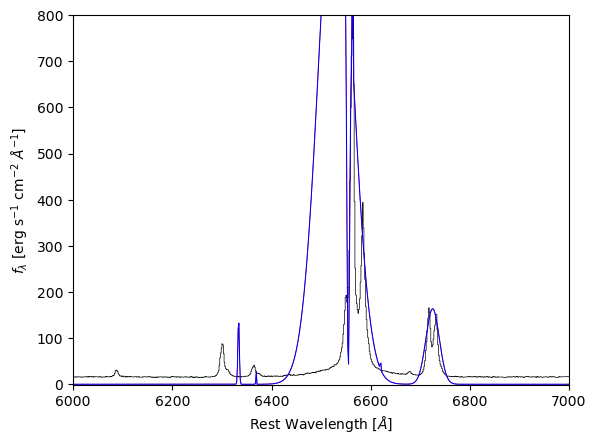

In [140]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=800,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

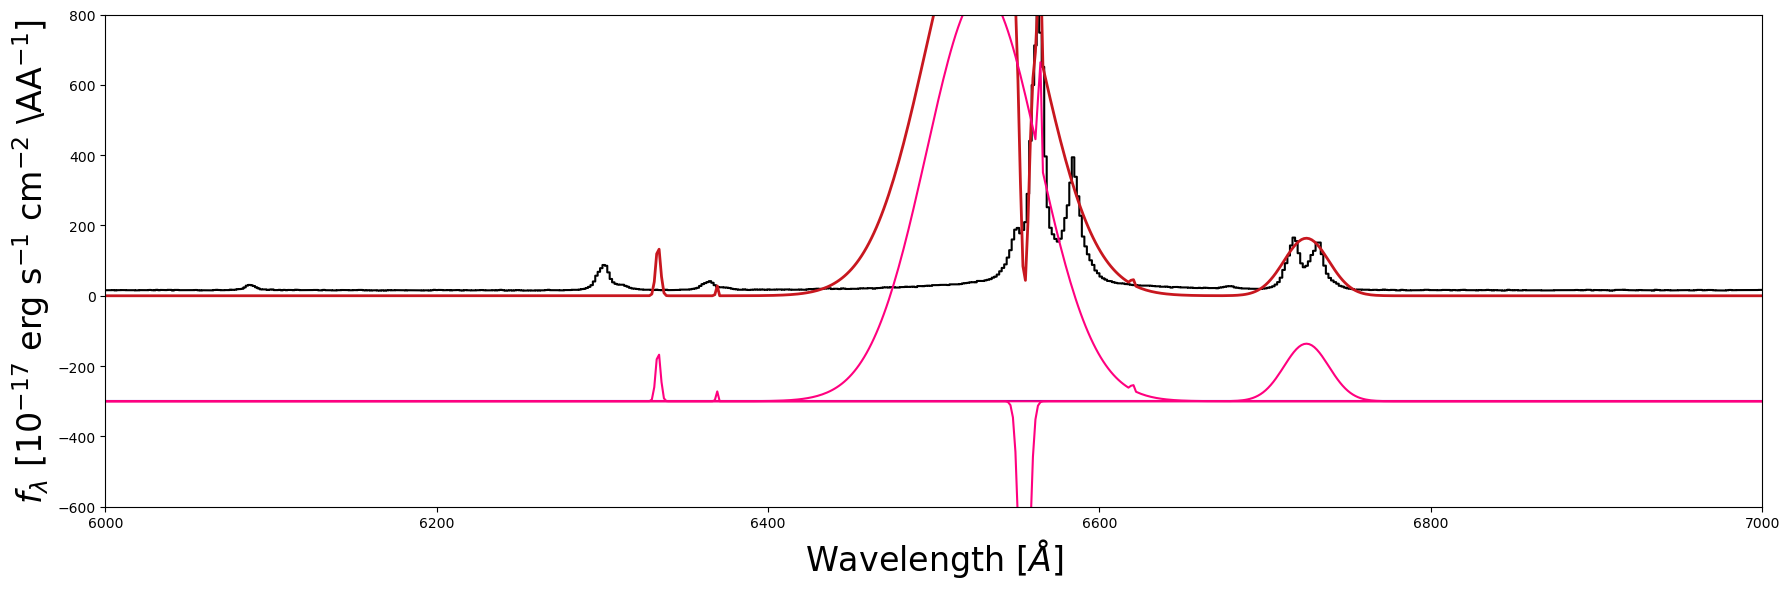

In [141]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-600,800,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)